# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

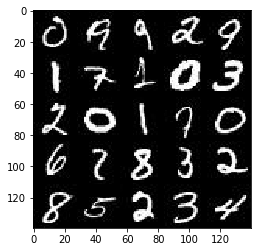

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

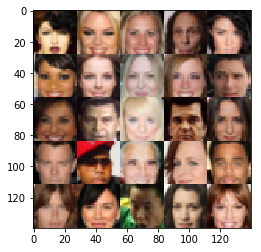

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='input')
    z = tf.placeholder(tf.float32, shape=[None, z_dim], name='z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        output = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        output = tf.maximum(alpha * output, output)
        
        output = tf.layers.conv2d(output, 64, 5, strides=2, padding='same')
        output = tf.layers.batch_normalization(output, training=True)
        output = tf.maximum(alpha * output, output)
        
        output = tf.layers.conv2d(output, 128, 5, strides=2, padding='same')
        output = tf.layers.batch_normalization(output, training=True)
        output = tf.maximum(alpha * output, output)
        
        output = tf.layers.conv2d(output, 256, 5, strides=2, padding='same')
        output = tf.layers.batch_normalization(output, training=True)
        output = tf.maximum(alpha * output, output)
        
        output = tf.reshape(output, (-1, 4*4*256))
        
        logits = tf.layers.dense(output, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        output = tf.layers.dense(z, 4*4*512)
        
        output = tf.reshape(output, (-1, 4, 4, 512))
        output = tf.layers.batch_normalization(output, training=is_train)
        output = tf.maximum(alpha * output, output)
        
        output = tf.layers.conv2d_transpose(output, 128, 4, strides=1, padding='valid')
        output = tf.layers.batch_normalization(output, training=is_train)
        output = tf.maximum(alpha * output, output)
        
        output = tf.layers.conv2d_transpose(output, 64, 5, strides=2, padding='same')
        output = tf.layers.batch_normalization(output, training=is_train)
        output = tf.maximum(alpha * output, output)
        
        output = tf.layers.conv2d_transpose(output, 32, 5, strides=2, padding='same')
        output = tf.layers.batch_normalization(output, training=is_train)
        output = tf.maximum(alpha * output, output)
        
        logits = tf.layers.conv2d_transpose(output, out_channel_dim, 3, strides=1, padding='same')
        
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real,
            labels=tf.ones_like(d_model_real)
        )
    )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_model_fake)
        )
    )
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_model_fake)
        )
    )
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_t, z_t, learning_rate_t = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_t, z_t, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_t, beta1)
    
    step = 0
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                
                random_noise = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Discriminator
                _ = sess.run(
                    d_opt,
                    feed_dict={
                        input_t: batch_images,
                        z_t: random_noise,
                        learning_rate_t: learning_rate
                    }
                )
                
                # Generator
                _ = sess.run(
                    g_opt,
                    feed_dict={
                        input_t: batch_images,
                        z_t: random_noise,
                        learning_rate_t: learning_rate
                    }
                )
                
                if step % 10 == 0:
                    train_loss_d = d_loss.eval({
                        z_t: random_noise,
                        input_t: batch_images
                    })
                    
                    train_loss_g = g_loss.eval({
                        z_t: random_noise
                    })
                    
                    print(
                        "Epoch {}/{}".format(epoch_i + 1, epoch_count),
                        "Discriminator Loss: {:.4f}".format(train_loss_d),
                        "Generator Loss: {:.4f}".format(train_loss_g)
                    )
                    losses.append((train_loss_d, train_loss_g))
                    
                if step % 100 == 0:
                    show_generator_output(sess, 7**2, z_t, image_channels, data_image_mode)
                    
        pyplot.subplots()
        losses = np.array(losses)
        pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
        pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
        pyplot.title('Training Losses')
        pyplot.legend()
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Discriminator Loss: 0.9835 Generator Loss: 0.8961
Epoch 1/2 Discriminator Loss: 0.7982 Generator Loss: 1.1869
Epoch 1/2 Discriminator Loss: 0.6539 Generator Loss: 1.1941
Epoch 1/2 Discriminator Loss: 0.5597 Generator Loss: 1.4839
Epoch 1/2 Discriminator Loss: 0.5915 Generator Loss: 1.3158
Epoch 1/2 Discriminator Loss: 0.4933 Generator Loss: 1.5688
Epoch 1/2 Discriminator Loss: 0.3991 Generator Loss: 1.7127
Epoch 1/2 Discriminator Loss: 0.3650 Generator Loss: 1.7988
Epoch 1/2 Discriminator Loss: 0.2125 Generator Loss: 2.3283
Epoch 1/2 Discriminator Loss: 0.2278 Generator Loss: 2.2158


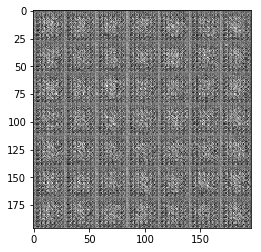

Epoch 1/2 Discriminator Loss: 0.2293 Generator Loss: 2.2485
Epoch 1/2 Discriminator Loss: 0.2390 Generator Loss: 2.2461
Epoch 1/2 Discriminator Loss: 0.2486 Generator Loss: 2.2236
Epoch 1/2 Discriminator Loss: 0.2229 Generator Loss: 2.2645
Epoch 1/2 Discriminator Loss: 0.1814 Generator Loss: 2.4615
Epoch 1/2 Discriminator Loss: 0.1628 Generator Loss: 2.5890
Epoch 1/2 Discriminator Loss: 0.1430 Generator Loss: 2.6954
Epoch 1/2 Discriminator Loss: 0.1592 Generator Loss: 2.5692
Epoch 1/2 Discriminator Loss: 0.1188 Generator Loss: 2.9118
Epoch 1/2 Discriminator Loss: 0.1523 Generator Loss: 2.7475


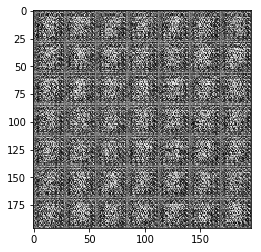

Epoch 1/2 Discriminator Loss: 0.1132 Generator Loss: 2.8895
Epoch 1/2 Discriminator Loss: 0.1372 Generator Loss: 2.6125
Epoch 1/2 Discriminator Loss: 0.1545 Generator Loss: 2.8109
Epoch 1/2 Discriminator Loss: 0.1350 Generator Loss: 2.5345
Epoch 1/2 Discriminator Loss: 0.1601 Generator Loss: 2.7641
Epoch 1/2 Discriminator Loss: 0.1036 Generator Loss: 2.8012
Epoch 1/2 Discriminator Loss: 0.1063 Generator Loss: 2.8976
Epoch 1/2 Discriminator Loss: 0.1447 Generator Loss: 2.8207
Epoch 1/2 Discriminator Loss: 0.1508 Generator Loss: 2.5316
Epoch 1/2 Discriminator Loss: 0.1625 Generator Loss: 2.7078


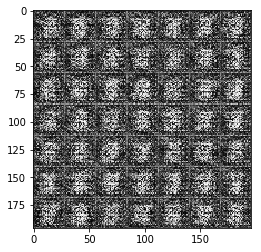

Epoch 1/2 Discriminator Loss: 0.1178 Generator Loss: 2.9767
Epoch 1/2 Discriminator Loss: 0.1378 Generator Loss: 2.8443
Epoch 1/2 Discriminator Loss: 0.1546 Generator Loss: 2.7089
Epoch 1/2 Discriminator Loss: 0.1862 Generator Loss: 2.5647
Epoch 1/2 Discriminator Loss: 0.1976 Generator Loss: 2.5568
Epoch 1/2 Discriminator Loss: 0.2618 Generator Loss: 2.2102
Epoch 1/2 Discriminator Loss: 0.3022 Generator Loss: 1.8504
Epoch 1/2 Discriminator Loss: 0.3211 Generator Loss: 2.1331
Epoch 1/2 Discriminator Loss: 0.3403 Generator Loss: 1.9954
Epoch 1/2 Discriminator Loss: 0.3743 Generator Loss: 1.8209


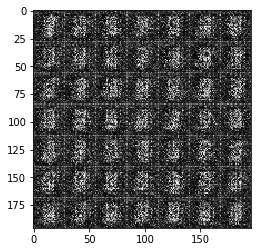

Epoch 1/2 Discriminator Loss: 0.4872 Generator Loss: 1.6518
Epoch 1/2 Discriminator Loss: 0.5894 Generator Loss: 1.5660
Epoch 1/2 Discriminator Loss: 0.5739 Generator Loss: 1.4988
Epoch 1/2 Discriminator Loss: 0.6401 Generator Loss: 1.4570
Epoch 1/2 Discriminator Loss: 0.5663 Generator Loss: 1.5967
Epoch 1/2 Discriminator Loss: 0.5336 Generator Loss: 1.6630
Epoch 2/2 Discriminator Loss: 0.4997 Generator Loss: 1.7031
Epoch 2/2 Discriminator Loss: 0.4163 Generator Loss: 2.0196
Epoch 2/2 Discriminator Loss: 0.4014 Generator Loss: 1.8308
Epoch 2/2 Discriminator Loss: 0.3656 Generator Loss: 2.1321


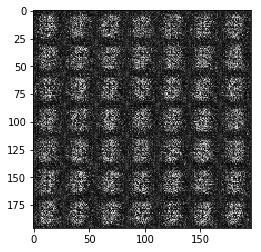

Epoch 2/2 Discriminator Loss: 0.3395 Generator Loss: 1.9403
Epoch 2/2 Discriminator Loss: 0.3064 Generator Loss: 2.1174
Epoch 2/2 Discriminator Loss: 0.3029 Generator Loss: 2.1565
Epoch 2/2 Discriminator Loss: 0.3242 Generator Loss: 2.2171
Epoch 2/2 Discriminator Loss: 0.2265 Generator Loss: 2.3246
Epoch 2/2 Discriminator Loss: 0.1828 Generator Loss: 2.6836
Epoch 2/2 Discriminator Loss: 0.1485 Generator Loss: 2.8675
Epoch 2/2 Discriminator Loss: 0.1916 Generator Loss: 2.5291
Epoch 2/2 Discriminator Loss: 0.2227 Generator Loss: 2.3964
Epoch 2/2 Discriminator Loss: 0.1470 Generator Loss: 2.6985


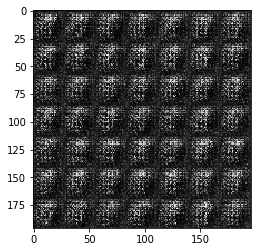

Epoch 2/2 Discriminator Loss: 0.1988 Generator Loss: 2.4326
Epoch 2/2 Discriminator Loss: 0.1550 Generator Loss: 2.7425
Epoch 2/2 Discriminator Loss: 0.1876 Generator Loss: 2.5272
Epoch 2/2 Discriminator Loss: 0.1524 Generator Loss: 2.6332
Epoch 2/2 Discriminator Loss: 0.1680 Generator Loss: 2.4564
Epoch 2/2 Discriminator Loss: 0.1107 Generator Loss: 3.1593
Epoch 2/2 Discriminator Loss: 0.1240 Generator Loss: 2.9781
Epoch 2/2 Discriminator Loss: 0.1704 Generator Loss: 2.7546
Epoch 2/2 Discriminator Loss: 0.1461 Generator Loss: 2.8425
Epoch 2/2 Discriminator Loss: 0.1999 Generator Loss: 2.8051


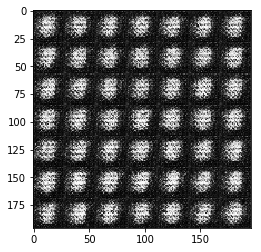

Epoch 2/2 Discriminator Loss: 0.1684 Generator Loss: 2.8320
Epoch 2/2 Discriminator Loss: 0.1065 Generator Loss: 3.0904
Epoch 2/2 Discriminator Loss: 0.0746 Generator Loss: 3.5144
Epoch 2/2 Discriminator Loss: 0.0840 Generator Loss: 3.3931
Epoch 2/2 Discriminator Loss: 0.1140 Generator Loss: 2.8149
Epoch 2/2 Discriminator Loss: 0.1504 Generator Loss: 2.7805
Epoch 2/2 Discriminator Loss: 0.1384 Generator Loss: 2.8229
Epoch 2/2 Discriminator Loss: 0.1190 Generator Loss: 3.0331
Epoch 2/2 Discriminator Loss: 0.1052 Generator Loss: 3.2221
Epoch 2/2 Discriminator Loss: 0.0903 Generator Loss: 3.1732


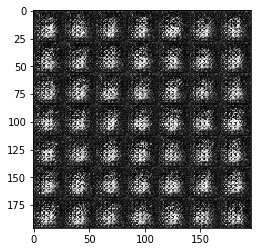

Epoch 2/2 Discriminator Loss: 0.0870 Generator Loss: 3.2947
Epoch 2/2 Discriminator Loss: 0.0702 Generator Loss: 3.5657
Epoch 2/2 Discriminator Loss: 0.0719 Generator Loss: 3.2385
Epoch 2/2 Discriminator Loss: 0.1219 Generator Loss: 3.2182
Epoch 2/2 Discriminator Loss: 0.1114 Generator Loss: 3.1638
Epoch 2/2 Discriminator Loss: 0.0963 Generator Loss: 3.2645
Epoch 2/2 Discriminator Loss: 0.1063 Generator Loss: 3.1551
Epoch 2/2 Discriminator Loss: 0.1290 Generator Loss: 2.9527
Epoch 2/2 Discriminator Loss: 0.1194 Generator Loss: 3.3791
Epoch 2/2 Discriminator Loss: 0.1069 Generator Loss: 3.1485


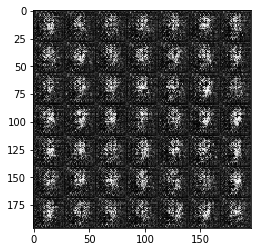

Epoch 2/2 Discriminator Loss: 0.1014 Generator Loss: 3.4697
Epoch 2/2 Discriminator Loss: 0.0991 Generator Loss: 3.3405
Epoch 2/2 Discriminator Loss: 0.1037 Generator Loss: 3.1919


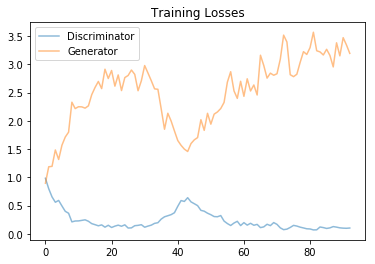

In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.00001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Discriminator Loss: 0.8618 Generator Loss: 0.9040
Epoch 1/1 Discriminator Loss: 0.8203 Generator Loss: 1.0189
Epoch 1/1 Discriminator Loss: 0.5342 Generator Loss: 1.2918
Epoch 1/1 Discriminator Loss: 0.4590 Generator Loss: 1.5182
Epoch 1/1 Discriminator Loss: 0.5660 Generator Loss: 1.4327
Epoch 1/1 Discriminator Loss: 0.3952 Generator Loss: 1.7511
Epoch 1/1 Discriminator Loss: 0.3669 Generator Loss: 1.7120
Epoch 1/1 Discriminator Loss: 0.3896 Generator Loss: 1.6728
Epoch 1/1 Discriminator Loss: 0.3255 Generator Loss: 1.9815
Epoch 1/1 Discriminator Loss: 0.3787 Generator Loss: 1.8151


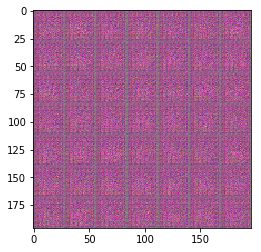

Epoch 1/1 Discriminator Loss: 0.2947 Generator Loss: 1.9300
Epoch 1/1 Discriminator Loss: 0.2971 Generator Loss: 1.9672
Epoch 1/1 Discriminator Loss: 0.2966 Generator Loss: 1.9695
Epoch 1/1 Discriminator Loss: 0.2414 Generator Loss: 2.0452
Epoch 1/1 Discriminator Loss: 0.2507 Generator Loss: 2.1983
Epoch 1/1 Discriminator Loss: 0.2438 Generator Loss: 2.2733
Epoch 1/1 Discriminator Loss: 0.1836 Generator Loss: 2.5582
Epoch 1/1 Discriminator Loss: 0.1830 Generator Loss: 2.3854
Epoch 1/1 Discriminator Loss: 0.1789 Generator Loss: 2.5836
Epoch 1/1 Discriminator Loss: 0.1652 Generator Loss: 2.6309


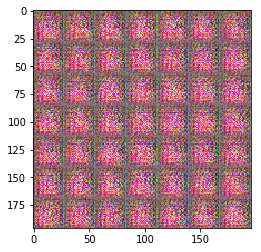

Epoch 1/1 Discriminator Loss: 0.2108 Generator Loss: 2.4032
Epoch 1/1 Discriminator Loss: 0.1767 Generator Loss: 2.6157
Epoch 1/1 Discriminator Loss: 0.2031 Generator Loss: 2.2794
Epoch 1/1 Discriminator Loss: 0.2749 Generator Loss: 2.1492
Epoch 1/1 Discriminator Loss: 0.1888 Generator Loss: 2.3748
Epoch 1/1 Discriminator Loss: 0.1880 Generator Loss: 2.3328
Epoch 1/1 Discriminator Loss: 0.1436 Generator Loss: 2.6829
Epoch 1/1 Discriminator Loss: 0.1802 Generator Loss: 2.5268
Epoch 1/1 Discriminator Loss: 0.1535 Generator Loss: 2.6463
Epoch 1/1 Discriminator Loss: 0.2250 Generator Loss: 2.5021


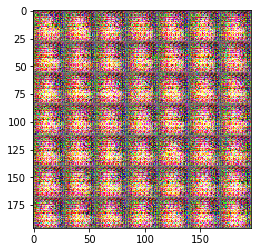

Epoch 1/1 Discriminator Loss: 0.1921 Generator Loss: 2.4105
Epoch 1/1 Discriminator Loss: 0.1575 Generator Loss: 2.6822
Epoch 1/1 Discriminator Loss: 0.1401 Generator Loss: 2.7343
Epoch 1/1 Discriminator Loss: 0.1856 Generator Loss: 2.7409
Epoch 1/1 Discriminator Loss: 0.1500 Generator Loss: 2.6114
Epoch 1/1 Discriminator Loss: 0.1590 Generator Loss: 2.9179
Epoch 1/1 Discriminator Loss: 0.1213 Generator Loss: 2.9737
Epoch 1/1 Discriminator Loss: 0.1290 Generator Loss: 2.9280
Epoch 1/1 Discriminator Loss: 0.1175 Generator Loss: 2.9586
Epoch 1/1 Discriminator Loss: 0.1918 Generator Loss: 2.7816


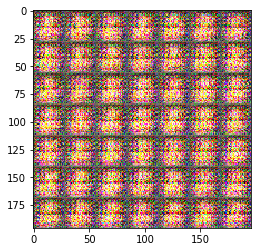

Epoch 1/1 Discriminator Loss: 0.2150 Generator Loss: 2.3959
Epoch 1/1 Discriminator Loss: 0.1695 Generator Loss: 2.8374
Epoch 1/1 Discriminator Loss: 0.1029 Generator Loss: 3.1799
Epoch 1/1 Discriminator Loss: 0.1062 Generator Loss: 3.1978
Epoch 1/1 Discriminator Loss: 0.1231 Generator Loss: 2.8279
Epoch 1/1 Discriminator Loss: 0.1625 Generator Loss: 3.0511
Epoch 1/1 Discriminator Loss: 0.0731 Generator Loss: 3.2252
Epoch 1/1 Discriminator Loss: 0.0852 Generator Loss: 3.3751
Epoch 1/1 Discriminator Loss: 0.0819 Generator Loss: 3.2674
Epoch 1/1 Discriminator Loss: 0.0930 Generator Loss: 3.3360


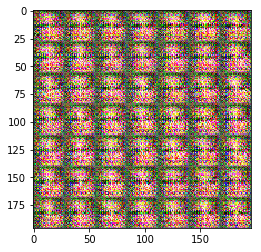

Epoch 1/1 Discriminator Loss: 0.0601 Generator Loss: 3.5055
Epoch 1/1 Discriminator Loss: 0.1316 Generator Loss: 3.2751
Epoch 1/1 Discriminator Loss: 0.0804 Generator Loss: 3.2240
Epoch 1/1 Discriminator Loss: 0.1321 Generator Loss: 2.7949
Epoch 1/1 Discriminator Loss: 0.1336 Generator Loss: 3.0999
Epoch 1/1 Discriminator Loss: 0.1195 Generator Loss: 2.9181
Epoch 1/1 Discriminator Loss: 0.1166 Generator Loss: 3.0878
Epoch 1/1 Discriminator Loss: 0.1475 Generator Loss: 2.9781
Epoch 1/1 Discriminator Loss: 0.0869 Generator Loss: 3.1316
Epoch 1/1 Discriminator Loss: 0.1443 Generator Loss: 3.0994


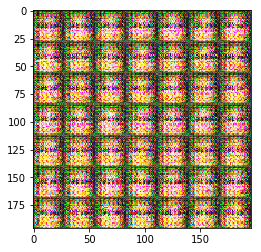

Epoch 1/1 Discriminator Loss: 0.1001 Generator Loss: 3.3892
Epoch 1/1 Discriminator Loss: 0.0847 Generator Loss: 3.3951
Epoch 1/1 Discriminator Loss: 0.1032 Generator Loss: 3.0667
Epoch 1/1 Discriminator Loss: 0.1106 Generator Loss: 3.1424
Epoch 1/1 Discriminator Loss: 0.0962 Generator Loss: 3.4326
Epoch 1/1 Discriminator Loss: 0.0949 Generator Loss: 3.3793
Epoch 1/1 Discriminator Loss: 0.0944 Generator Loss: 3.2859
Epoch 1/1 Discriminator Loss: 0.1377 Generator Loss: 2.9133
Epoch 1/1 Discriminator Loss: 0.1353 Generator Loss: 3.0275
Epoch 1/1 Discriminator Loss: 0.0925 Generator Loss: 3.2863


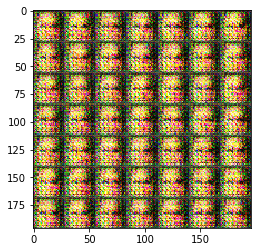

Epoch 1/1 Discriminator Loss: 0.1041 Generator Loss: 3.1735
Epoch 1/1 Discriminator Loss: 0.0538 Generator Loss: 3.5005
Epoch 1/1 Discriminator Loss: 0.0536 Generator Loss: 3.7190
Epoch 1/1 Discriminator Loss: 0.0597 Generator Loss: 3.8895
Epoch 1/1 Discriminator Loss: 0.0689 Generator Loss: 3.2519
Epoch 1/1 Discriminator Loss: 0.0917 Generator Loss: 3.4174
Epoch 1/1 Discriminator Loss: 0.0813 Generator Loss: 3.4534
Epoch 1/1 Discriminator Loss: 0.0740 Generator Loss: 3.5802
Epoch 1/1 Discriminator Loss: 0.0748 Generator Loss: 3.4910
Epoch 1/1 Discriminator Loss: 0.0690 Generator Loss: 3.5701


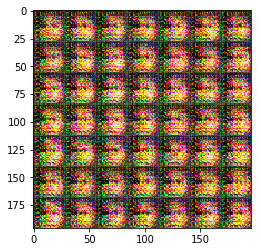

Epoch 1/1 Discriminator Loss: 0.0540 Generator Loss: 3.5816
Epoch 1/1 Discriminator Loss: 0.0642 Generator Loss: 3.6094
Epoch 1/1 Discriminator Loss: 0.0567 Generator Loss: 3.7427
Epoch 1/1 Discriminator Loss: 0.0472 Generator Loss: 3.6748
Epoch 1/1 Discriminator Loss: 0.0412 Generator Loss: 3.7742
Epoch 1/1 Discriminator Loss: 0.0601 Generator Loss: 3.5969
Epoch 1/1 Discriminator Loss: 0.0461 Generator Loss: 3.6748
Epoch 1/1 Discriminator Loss: 0.0420 Generator Loss: 3.9502
Epoch 1/1 Discriminator Loss: 0.0504 Generator Loss: 3.6992
Epoch 1/1 Discriminator Loss: 0.0409 Generator Loss: 3.7509


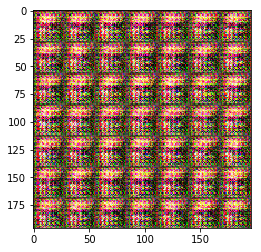

Epoch 1/1 Discriminator Loss: 0.0457 Generator Loss: 3.8950
Epoch 1/1 Discriminator Loss: 0.0627 Generator Loss: 3.7160
Epoch 1/1 Discriminator Loss: 0.0362 Generator Loss: 3.9900
Epoch 1/1 Discriminator Loss: 0.0679 Generator Loss: 3.8650
Epoch 1/1 Discriminator Loss: 0.0614 Generator Loss: 3.7909
Epoch 1/1 Discriminator Loss: 0.0737 Generator Loss: 3.4825
Epoch 1/1 Discriminator Loss: 0.0664 Generator Loss: 3.6934
Epoch 1/1 Discriminator Loss: 0.0880 Generator Loss: 3.4461
Epoch 1/1 Discriminator Loss: 0.0623 Generator Loss: 3.7404
Epoch 1/1 Discriminator Loss: 0.0670 Generator Loss: 3.9287


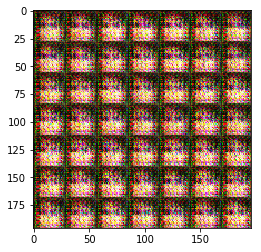

Epoch 1/1 Discriminator Loss: 0.0397 Generator Loss: 4.1296
Epoch 1/1 Discriminator Loss: 0.0299 Generator Loss: 4.2910
Epoch 1/1 Discriminator Loss: 0.0775 Generator Loss: 3.8521
Epoch 1/1 Discriminator Loss: 0.0414 Generator Loss: 3.9353
Epoch 1/1 Discriminator Loss: 0.0488 Generator Loss: 3.9086
Epoch 1/1 Discriminator Loss: 0.1152 Generator Loss: 3.4635
Epoch 1/1 Discriminator Loss: 0.0603 Generator Loss: 3.6229
Epoch 1/1 Discriminator Loss: 0.0537 Generator Loss: 3.7561
Epoch 1/1 Discriminator Loss: 0.0480 Generator Loss: 4.0506
Epoch 1/1 Discriminator Loss: 0.0291 Generator Loss: 3.9984


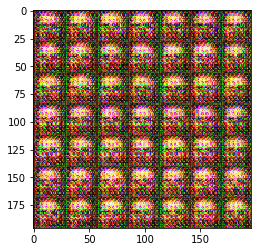

Epoch 1/1 Discriminator Loss: 0.0555 Generator Loss: 3.7581
Epoch 1/1 Discriminator Loss: 0.0771 Generator Loss: 3.7684
Epoch 1/1 Discriminator Loss: 0.0382 Generator Loss: 3.9422
Epoch 1/1 Discriminator Loss: 0.0546 Generator Loss: 4.0143
Epoch 1/1 Discriminator Loss: 0.0655 Generator Loss: 3.7232
Epoch 1/1 Discriminator Loss: 0.0668 Generator Loss: 3.2682
Epoch 1/1 Discriminator Loss: 0.0943 Generator Loss: 3.4162
Epoch 1/1 Discriminator Loss: 0.0875 Generator Loss: 3.3464
Epoch 1/1 Discriminator Loss: 0.1180 Generator Loss: 3.2783
Epoch 1/1 Discriminator Loss: 0.0846 Generator Loss: 3.7233


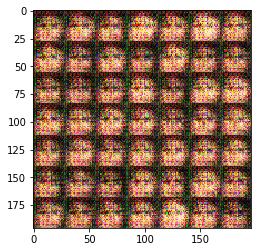

Epoch 1/1 Discriminator Loss: 0.1160 Generator Loss: 3.4762
Epoch 1/1 Discriminator Loss: 0.0755 Generator Loss: 3.2416
Epoch 1/1 Discriminator Loss: 0.1087 Generator Loss: 3.0219
Epoch 1/1 Discriminator Loss: 0.1251 Generator Loss: 3.1754
Epoch 1/1 Discriminator Loss: 0.2512 Generator Loss: 2.3354
Epoch 1/1 Discriminator Loss: 0.0965 Generator Loss: 3.5002
Epoch 1/1 Discriminator Loss: 0.1600 Generator Loss: 2.6914
Epoch 1/1 Discriminator Loss: 0.1099 Generator Loss: 3.0075
Epoch 1/1 Discriminator Loss: 0.1383 Generator Loss: 2.7708
Epoch 1/1 Discriminator Loss: 0.1304 Generator Loss: 2.9499


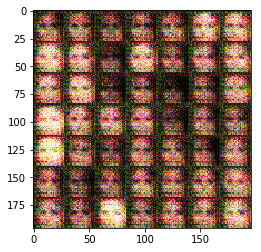

Epoch 1/1 Discriminator Loss: 0.1182 Generator Loss: 3.1024
Epoch 1/1 Discriminator Loss: 0.0720 Generator Loss: 3.5260
Epoch 1/1 Discriminator Loss: 0.1284 Generator Loss: 3.0478
Epoch 1/1 Discriminator Loss: 0.0939 Generator Loss: 3.0438
Epoch 1/1 Discriminator Loss: 0.1955 Generator Loss: 2.5140
Epoch 1/1 Discriminator Loss: 0.1218 Generator Loss: 3.0508
Epoch 1/1 Discriminator Loss: 0.1012 Generator Loss: 2.8724
Epoch 1/1 Discriminator Loss: 0.0883 Generator Loss: 3.4407
Epoch 1/1 Discriminator Loss: 0.1008 Generator Loss: 3.0522
Epoch 1/1 Discriminator Loss: 0.1248 Generator Loss: 2.9346


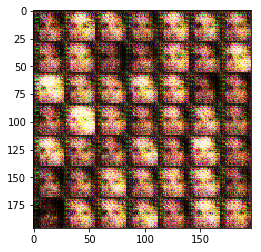

Epoch 1/1 Discriminator Loss: 0.0809 Generator Loss: 3.3525
Epoch 1/1 Discriminator Loss: 0.1717 Generator Loss: 2.6721
Epoch 1/1 Discriminator Loss: 0.1342 Generator Loss: 3.0965
Epoch 1/1 Discriminator Loss: 0.1198 Generator Loss: 3.0685
Epoch 1/1 Discriminator Loss: 0.0938 Generator Loss: 3.5262
Epoch 1/1 Discriminator Loss: 0.1049 Generator Loss: 3.2009
Epoch 1/1 Discriminator Loss: 0.1164 Generator Loss: 3.1475
Epoch 1/1 Discriminator Loss: 0.0900 Generator Loss: 3.0693
Epoch 1/1 Discriminator Loss: 0.0961 Generator Loss: 3.3252
Epoch 1/1 Discriminator Loss: 0.0953 Generator Loss: 3.1769


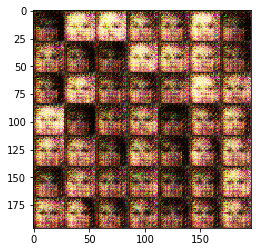

Epoch 1/1 Discriminator Loss: 0.0757 Generator Loss: 3.4858
Epoch 1/1 Discriminator Loss: 0.0740 Generator Loss: 3.3253
Epoch 1/1 Discriminator Loss: 0.0720 Generator Loss: 3.4591
Epoch 1/1 Discriminator Loss: 0.1589 Generator Loss: 2.9693
Epoch 1/1 Discriminator Loss: 0.0825 Generator Loss: 3.1723
Epoch 1/1 Discriminator Loss: 0.0917 Generator Loss: 3.5618
Epoch 1/1 Discriminator Loss: 0.1188 Generator Loss: 3.2414
Epoch 1/1 Discriminator Loss: 0.0855 Generator Loss: 3.4927


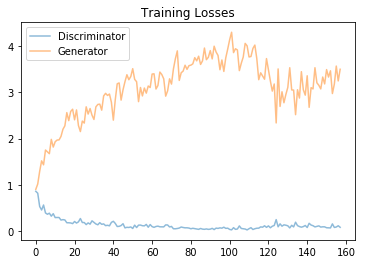

In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.00001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.